# **<font color="#FBBF44">Imports</font>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#!pip install gurobipy
import gurobipy as gp
from gurobipy import Model, GRB, quicksum

# **<font color="#FBBF44">Functions</font>**

In [2]:
# Time limits for different sets of instances
timelimCE = 3600
# To store runtimes and objective values
times = []
objectives = []

# Cost factors for large and Small vehicles
a1 = np.random.randint(5,10)/10 # = .8
a2 = a1*.75 # = .6

# Instance generator
def instance_gen(seed, clients, S1, S2, Q1, dmin, dmax):
    np.random.seed(seed) # Initial seed
    n = clients # number of clients
    # random location of clients within 8km radius
    xc = np.random.rand(n+1)*8 
    yc = np.random.rand(n+1)*8
    points = range(0,n+1)

    N = [i for i in range(1, n + 1)] # Set of clients
    V = [0] + N # Set of all nodes, including depot
    A = [(i,j) for i in V for j in V if i != j] # Available arcs between nodes
    
    S = S1 + S2 # Total amount of available vehicles
    K = [i for i in range(1, S + 1)] # Number of available vehicles, including large and small
    K1 = [i for i in range(1, S1 + 1)] # subset of large vehicles
    K2 = [i for i in range(S1+1, S1+S2+1)] # subset of small vehicles
    
    Ak = [(i,j,k) for k in K for i in V for j in V if i != j] # Available arcs between nodes for each vehicle
    Q = {} # Capacities
    for i in K:
        if i in K1:
            Q[i] = Q1 
        else:
            Q[i] = Q1/2

    d = {i: np.random.randint(dmin, dmax) for i in N} # Random demands from customers

    a1 = .8
    a2 = .6

    d1 = {(i,j,1): (np.hypot(xc[i] - xc[j], yc[i] - yc[j])) + np.random.rand() for i, j in A}
    d2 = {(i,j,2): d1[i,j,1] for i, j in A}
    c1 = {k:v*a1 for k, v in d1.items()} # Cost for traversing i,j with LargeVehicle
    c2 = {k:v*a2 for k, v in d2.items()} # Cost for traversing i,j with SmallVehicle
    c = dict(c1)
    c.update(c2) 
    return n, xc, yc, points, list(N), V, K, K1, K2, A, Ak, S, Q, d, c

In [3]:
# Building the model
def build_model(model):
    model = gp.Model()
    x = model.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
    y = model.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
    u = model.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
    z = model.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
    M = 1000 # Big M

    # objective
    model.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2), GRB.MINIMIZE)
    # (1)
    c1 = model.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
    # (2)
    c2 = model.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
    # (3)
    c3 = model.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
    # (4)
    c4 = model.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
    # (5)
    c5 = model.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
    # (6)
    c6 = model.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
    # (7)
    c7 = model.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
    # (8)
    c8 = model.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
    c8_2 = model.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)
    
    return model, x, y, u, z, c2

In [4]:
# Plotting solution
def plot_sol(xc, yc, K1, K2, active_arcs, name):
    colors = ["teal", "darkorange", "violet", "indigo", "turquoise", "crimson", "gold", "limegreen", "royalblue"]
    plt.plot(xc[0], yc[0], c='red', marker='s', label="Depot")
    plt.scatter(xc[1:], yc[1:], label="Clients")
#     for i in range(len(xc)):
#         plt.annotate(points[i], (xc[i] - .5, yc[i] + 0.4))
    
    for k in K1:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k-1], lw=1.5, mutation_scale=15))
    for k in K2:
        for i,j,k in active_arcs:
            plt.annotate(text='', xy=(xc[j],yc[j]), xytext=(xc[i],yc[i]), zorder=0, 
                         arrowprops=dict(arrowstyle= '->, head_length=.5', color = colors[k-1], lw=1.5, mutation_scale=15))

    plt.xlim((-0.5, 8.5))
    plt.ylim((-0.5, 8.5))
    handles, labels = plt.gca().get_legend_handles_labels()
    lines = {}
    K = K1 + K2
    for k in K:
        if k in K1:
            lines[k] = Line2D([0], [0], label='LargeVehicle {}'.format(k), color = colors[k-1]) #, color='teal')
        else:
            lines[k] = Line2D([0], [0], label='SmallVehicle {}'.format(k), color = colors[k-1]) #, color='teal')

    handles.extend(lines.values())

    plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
    plt.title("Selected routes for {}".format(name))
    plt.savefig("FigXX-Tour{}".format(name)+".png", bbox_inches='tight', dpi=600) 
    plt.show()

In [5]:
# Finding the edges from solution values, as a tuplelist for each k
def selected(vals):
    s = {k:gp.tuplelist() for k in K}
    for i, j, k in vals.keys():
        if vals[i,j,k] > 0.99:
            s[k].append((i,j))
    return s
       
# Given the edges, finding the optimal route for each k
def subtour(edges):
    nodes = set(i for e in edges for i in e)
    unvisited = list(nodes)
    cycle = list(nodes)
    while unvisited:  
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(thiscycle) <= len(cycle): # even if it's the same, we reuse it so that we get the final tour in order
            cycle = thiscycle # New shortest subtour
    return cycle

# Print each tour
def print_route(objective, edges):
    print(f"The optimal cost for the distance traveled is: {(round(objective,2))} €")
    for k in K:
        tour = subtour(edges[k])
        tour.append(0) # return to depot
        print ("Route for vehicle k%i: %s" % (k, " -> ".join(map(str, tour))))

In [6]:
# Check for feasibility by confirming total delivery and delivery by vehicle doesn't exceed capacities, also check if customers are satisfied
def feasibility_check(yvals):
    total_demand = 0
    print("---------------------------")
    print("Feasibility check:")
    print(f"Total capacity: {sum(Q.values())}")
    print(f"Total amount delivered: {sum(d.values())}")
    print(f"Capacity of large vehicles: {Q[1]}")
    # Get amount delivered by each k vehicle
    for k in K:
        delivery_by_vehicle = [yvals[i,j] for i,j in yvals if j == k] 
        print("Amount delivered by vehicle k%i: %i" % (k, sum(delivery_by_vehicle)))
        if sum(delivery_by_vehicle) > Q[k]:
            exceedsQ = "Yes"
        else:
            exceedsQ = "No"
    # Get amount delivered to each customer, independent of k
    for h in N:
        delivery_to_costumer = [yvals[i,j] for i,j in yvals if i == h]
        total_demand += d[h]
        if sum(delivery_to_costumer) == d[h]:
            customers_satisfied = "Yes"
        else: 
            customers_satisfied = "No"
    if sum(d.values()) <= sum(Q.values()) and exceedsQ == "No" and customers_satisfied == "Yes":
        print(f"Total demand %i is satisfied, capacities are respected, model is feasible" % (total_demand))
    else:
        print("Model is infeasible")
        print(f"The total demand was: %i" % (total_demand))

In [7]:
# Function for parameter tuning
def print_tuning(model, timelimit):
    model.Params.TuneTimeLimit = timelimit
    model.tune()
    for i in range(model.tuneResultCount):
        model.getTuneResult(i)
        model.write('tune'+str(i)+'.prm')

In [8]:
# Function to see which MIPFocus performs best on first seconds of optimization
def MIPcomparison(model, timelimit):
    gaps = []
    model.Params.TimeLimit = timelimit
    model.Params.OutPutFlag = 0
    for i in range(0, 4):
        model.reset()
        model.Params.MIPFocus = i
        model.optimize()
        gaps.append(model.MIPGap)
    print(f"MIPFocus 0,1,2,3:{gaps}")

In [9]:
# Retrieve gaps and runtimes from the log file
def gap_runtime(instance):
    gap = []
    runtime = []
    incumbent = []
    bestbd = []
    with open(instance+".log") as file:
        for line in file:
            if "Node Time" in line:
                for line in file:
                    row = line.split() 
                    row = [r.strip("%") for r in row]
                    row = [r.strip("s") for r in row]
                    gap.append(row[-3:])
                    runtime.append(row[-1:])
                    incumbent.append(row[-5:])
                    bestbd.append(row[-4:])
                    if "Cutting" in line:
                        break
    gap = gap[1:-2]
    for i in gap:
        del i[1:3]
    gap = [i[0] for i in gap]
    for i in range(len(gap)):
        if gap[i] == '-':
            gap[i] = 100
    gap = [float(i) for i in gap]

    runtime = runtime[1:-2]
    runtime = [int(i[0]) for i in runtime]

    incumbent = incumbent[1:-2]
    for i in incumbent:
        del i[1:3]
    incumbent = [i[0] for i in incumbent]
    for i in range(len(incumbent)):
        if incumbent[i] == '-':
            incumbent[i] = incumbent[i+1]
    incumbent = [float(i) for i in incumbent]

    bestbd = bestbd[1:-2]
    bestbd = [float(i[0]) for i in bestbd]
    
    return gap, runtime, incumbent, bestbd

# **<font color="#BBBF">CE INSTANCES</font>**

## **<font color="#FBBF44">CE-01</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Set parameter TimeLimit to value 1200
Set parameter LogFile to value "CE-01.log"
Set parameter NoRelHeurTime to value 50
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6606 rows, 3520 columns and 25920 nonzeros
Model fingerprint: 0x3bcde23c
Variable types: 0 continuous, 3520 integer (3360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 109.295

Presolve removed 3162 rows and 40 columns
Presolve time: 0.05s
Presolved: 3444 rows, 3480 columns, 19520 nonzeros
Crushed 2 out of 2 user cuts to presolved model
Variable types: 0 continuous, 3480 integer (3360 binary)
Starting NoRel heuristic
Found heuristic solutio

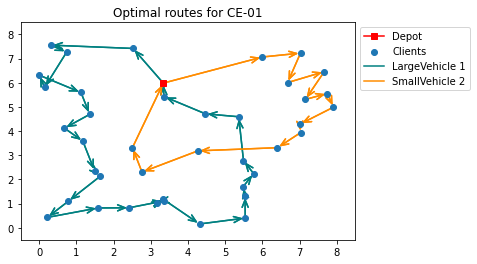

The optimal cost for the distance traveled is: 42.87 €
Route for vehicle k1: 0 -> 35 -> 27 -> 5 -> 38 -> 2 -> 18 -> 28 -> 26 -> 4 -> 6 -> 12 -> 30 -> 14 -> 19 -> 3 -> 31 -> 8 -> 16 -> 9 -> 23 -> 34 -> 11 -> 1 -> 36 -> 15 -> 17 -> 10 -> 0
Route for vehicle k2: 0 -> 39 -> 29 -> 37 -> 32 -> 25 -> 21 -> 40 -> 24 -> 13 -> 20 -> 33 -> 7 -> 22 -> 0
Runtime = 1159.526647567749
---------------------------
Feasibility check:
Total capacity: 600.0
Total amount delivered: 523
Capacity of large vehicles: 400
Amount delivered by vehicle k1: 351
Amount delivered by vehicle k2: 172
All customers are satisfied, capacities are respected, model is feasible


In [10]:
# With user cuts + Params 
############ Instance Initialization CE-01 ############
name = "CE-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=40,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=400,
                                                                     dmin=12,
                                                                     dmax=15)
############ model6 Construction ############
model6, x, y, u, z, c2 = build_model("model6")
for k in c2:
    c2[k].Lazy = -1

############ model6 Solving ############
model6.reset()
model6.Params.TimeLimit = timelimCE  # Time limit
model6.Params.LogFile = name+".log"
# model6.Params.Cuts = 2
model6.Params.NoRelHeurTime = 50
# model6.Params.MIPFocus = 3
model6.read("MIPStarts\CE-01.sol")
model6.optimize()

############ Plotting Solution ############
if model6.solcount >= 1:
#     model6.write(name+"x.sol")
#     model6.write(name+".mps")
#     model6.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model6.getAttr('X', x)
    yvals = model6.getAttr('X', y)
    print_route(objective=model6.objVal, edges=selected(vals))
    times.append(model6.runtime)
    print(f"Runtime = {model6.runtime}")
    feasibility_check(yvals)
    objectives.append(model6.objVal)
else:
    print("No feasible solution found")

Discarded solution information
Set parameter LogFile to value "CE-01.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 6606 rows, 10330 columns and 32730 nonzeros
Model fingerprint: 0xf41aeb5f
Variable types: 6810 continuous, 3520 integer (3360 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 525.0000000
Presolve removed 0 rows and 40 columns
Presolve time: 0.03s
Presolved: 6606 rows, 10290 columns, 32690 nonzeros
Variable types: 0 continuous, 10290 integer (3360 binary)

Root relaxation: objective 0.000000e+00, 1210 iterations, 0.07 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.0

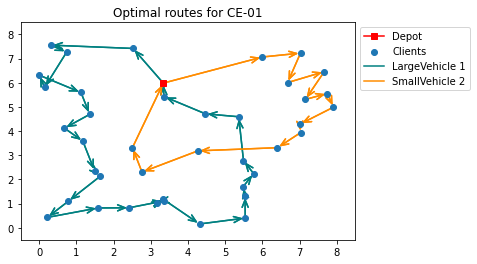

The optimal cost for the distance traveled is: 42.87 €
Route for vehicle k1: 0 -> 35 -> 27 -> 5 -> 38 -> 2 -> 18 -> 28 -> 26 -> 4 -> 6 -> 12 -> 30 -> 14 -> 19 -> 3 -> 31 -> 8 -> 16 -> 9 -> 23 -> 34 -> 11 -> 1 -> 36 -> 15 -> 17 -> 10 -> 0
Route for vehicle k2: 0 -> 39 -> 29 -> 37 -> 32 -> 25 -> 21 -> 40 -> 24 -> 13 -> 20 -> 33 -> 7 -> 22 -> 0
Runtime = 781.9689712524414
---------------------------
Feasibility check:
Total capacity: 600.0
Total amount delivered: 523
Capacity of large vehicles: 400
Amount delivered by vehicle k1: 351
Amount delivered by vehicle k2: 172
All customers are satisfied, capacities are respected, model is feasible


In [13]:
# Slack variables
############ Instance Initialization CE-01 ############
name = "CE-01"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=1,
                                                                     clients=40,
                                                                     S1=1,
                                                                     S2=1,
                                                                     Q1=400,
                                                                     dmin=12,
                                                                     dmax=15)
############ model6 Construction ############
model6, x, y, u, z, c2 = build_model("model6")

############ model6 Solving ############
model6.reset()
model6.Params.LogFile = name+".log"
model6x = model6.copy()
model6x.setObjective(0.0)
for c in model6x.getConstrs():
    sense = c.Sense
    if sense != '>':
        model6x.addVar(obj=1.0, name="ArtN_" + c.ConstrName, column=gp.Column([-1], [c]))
    if sense != '<':
        model6x.addVar(obj=1.0, name="ArtP_" + c.ConstrName, column=gp.Column([1], [c]))
model6x.optimize()
model6.feasRelaxS(0, True, False, True)
model6.Params.TimeLimit = timelimCE  # Time limit
model6.optimize()

############ Plotting Solution ############
if model6.solcount >= 1:
#     model6.write(name+"x.sol")
#     model6.write(name+".mps")
#     model6.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model6.getAttr('X', x)
    yvals = model6.getAttr('X', y)
    print_route(objective=model6.objVal, edges=selected(vals))
    times.append(model6.runtime)
    print(f"Runtime = {model6.runtime}")
    feasibility_check(yvals)
    objectives.append(model6.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-02</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Set parameter TimeLimit to value 3600
Set parameter NoRelHeurTime to value 600
Set parameter LogFile to value "CE-02.log"
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 122468 rows, 31500 columns and 4817700 nonzeros
Model fingerprint: 0xfa2aac45
Variable types: 15300 continuous, 16200 integer (15600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 106500 rows and 15300 columns
Presolve time: 1.50s
Presolved: 15968 rows, 16200 columns, 91800 nonzeros
Crushed 6 out of 91800 user cuts to presolved model
Variable types: 0 continuous, 16200 integer (15600 binary)
Starting NoRel heuristic
Found heuristic solution: objective 324.6745598
Found heuristic solution: ob

Elapsed time for NoRel heuristic: 209s (best bound 40.4102)
Elapsed time for NoRel heuristic: 220s (best bound 40.4102)
Elapsed time for NoRel heuristic: 228s (best bound 40.4102)
Elapsed time for NoRel heuristic: 239s (best bound 40.4102)
Found heuristic solution: objective 68.5932163
Found heuristic solution: objective 68.4863298
Elapsed time for NoRel heuristic: 278s (best bound 40.4102)
Elapsed time for NoRel heuristic: 291s (best bound 40.4102)
Found heuristic solution: objective 68.1771805
Elapsed time for NoRel heuristic: 303s (best bound 40.4102)
Elapsed time for NoRel heuristic: 316s (best bound 40.4102)
Found heuristic solution: objective 68.1771788
Elapsed time for NoRel heuristic: 328s (best bound 40.4102)
Elapsed time for NoRel heuristic: 339s (best bound 40.4102)
Found heuristic solution: objective 67.9816464
Elapsed time for NoRel heuristic: 350s (best bound 40.4102)
Elapsed time for NoRel heuristic: 365s (best bound 40.4102)
Elapsed time for NoRel heuristic: 380s (best 

  2761  2463   53.18328   55  319   67.51934   51.80270  23.3%  71.7  865s
  2839  2527   53.89935   64  344   67.51934   51.80270  23.3%  75.2  870s
  2934  2575   56.73038   71  380   67.51934   51.80270  23.3%  76.8  876s
  2977  2631   56.05944   75  363   67.51934   51.80270  23.3%  77.5  881s
  3087  2698   60.66278   85  326   67.51934   51.80270  23.3%  80.0  885s
  3173  2756   57.32050   94  322   67.51934   51.80270  23.3%  83.1  891s
  3270  2815   57.67414  103  321   67.51934   51.80270  23.3%  85.3  895s
  3479  2968   59.12852  118  305   67.51934   51.80270  23.3%  87.0  900s
  3615  3004   59.26725  130  320   67.51934   51.80270  23.3%  87.3  905s
  3760  3110   61.88253  153  308   67.51934   51.80270  23.3%  89.1  913s
  3811  3211   62.24779  160  232   67.51934   51.80270  23.3%  89.7  915s
  3992  3367   63.33146  187  243   67.51934   51.80270  23.3%  89.4  921s
  4305  3516   63.96399  234  209   67.51934   51.80291  23.3%  88.7  926s
  4517  3658   54.76658  

 22636 17926   61.59493  140  322   67.51934   52.10165  22.8%  80.7 1726s
 22718 18040   60.61932  163  323   67.51934   52.10165  22.8%  80.8 1730s
 22868 18067   61.45392  211  305   67.51934   52.10165  22.8%  80.9 1736s
 22951 18213   61.71416  244  278   67.51934   52.10165  22.8%  80.9 1741s
 23135 18217   65.06678  298  326   67.51934   52.10165  22.8%  81.0 1745s
 23237 18359   53.20891   50  655   67.51934   52.10165  22.8%  81.1 1751s
 23415 18486   54.18190   78  523   67.51934   52.10165  22.8%  81.3 1756s
 23607 18573   54.80076  117  515   67.51934   52.10165  22.8%  81.4 1762s
 23767 18648   55.05020  142  530   67.51934   52.10165  22.8%  81.4 1768s
 23946 18748   55.42140  173  487   67.51934   52.10165  22.8%  81.4 1774s
 24106 19018   55.99540  208  452   67.51934   52.10165  22.8%  81.3 1780s
 24429 19110   59.36911  256  380   67.51934   52.10165  22.8%  80.9 1787s
 24630 19320   62.77503  292  464   67.51934   52.10165  22.8%  80.8 1793s
 24910 19366   64.68712  

 64512 42681   55.91440   72  343   67.51934   52.36695  22.4%  71.5 2680s
 64833 42781   57.27883  155  298   67.51934   52.36695  22.4%  71.5 2689s
 65071 43051   59.53939  195  291   67.51934   52.36695  22.4%  71.6 2700s
 65475 43071   65.11882  226  187   67.51934   52.37028  22.4%  71.6 2708s
 65649 43165   54.53100   63  605   67.51934   52.37028  22.4%  71.9 2716s
 65847 43225   56.41200   90  548   67.51934   52.37028  22.4%  72.1 2726s
 66009 43405   58.02185  132  450   67.51934   52.37028  22.4%  72.2 2735s
 66296 43912   59.66597  237  465   67.51934   52.37028  22.4%  72.2 2745s
 66898 44233   60.70984  419  487   67.51934   52.37028  22.4%  72.0 2755s
 67447 44593   62.76023  580  378   67.51934   52.37028  22.4%  71.8 2764s
 68002 44667   65.21113  769  381   67.51934   52.37582  22.4%  71.6 2774s
 68317 44850   52.78578   45  798   67.51934   52.38161  22.4%  71.6 2782s
 68606 45158   55.46364   59  589   67.51934   52.38161  22.4%  71.7 2794s
 69011 45789   57.30557  


Cutting planes:
  User: 6
  Learned: 2
  Gomory: 172
  Lift-and-project: 6
  Cover: 55
  Implied bound: 257
  Projected implied bound: 22
  Clique: 7
  MIR: 158
  StrongCG: 8
  Flow cover: 544
  Inf proof: 20
  Zero half: 245
  RLT: 25
  Relax-and-lift: 61

Explored 102245 nodes (7093708 simplex iterations) in 3600.42 seconds (5139.67 work units)
Thread count was 8 (of 8 available processors)

Solution count 10: 67.5193 67.5193 67.5193 ... 67.9816

Time limit reached
         (model may be infeasible or unbounded - try turning presolve off)
Best objective 6.751934128940e+01, best bound 5.248346945230e+01, gap 22.2690%


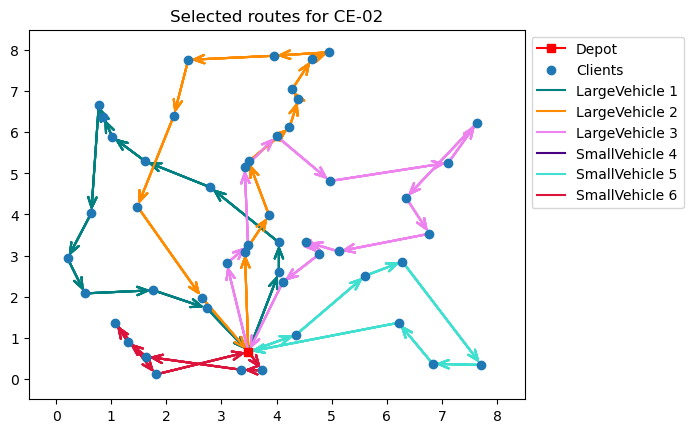

The optimal cost for the distance traveled is: 67.52 €
Route for vehicle k1: 0 -> 20 -> 34 -> 29 -> 31 -> 24 -> 27 -> 23 -> 19 -> 1 -> 21 -> 28 -> 43 -> 0
Route for vehicle k2: 0 -> 22 -> 33 -> 46 -> 11 -> 2 -> 48 -> 37 -> 7 -> 17 -> 8 -> 9 -> 14 -> 5 -> 0
Route for vehicle k3: 0 -> 35 -> 3 -> 45 -> 41 -> 10 -> 42 -> 49 -> 36 -> 18 -> 32 -> 44 -> 25 -> 13 -> 0
Route for vehicle k4: 0
Route for vehicle k5: 0 -> 50 -> 39 -> 15 -> 40 -> 16 -> 47 -> 0
Route for vehicle k6: 0 -> 30 -> 4 -> 6 -> 38 -> 12 -> 26 -> 0
Runtime = 3600.4462127685547
---------------------------
Feasibility check:
Total capacity: 765.0
Total amount delivered: 645
Capacity of large vehicles: 170
Amount delivered by vehicle k1: 156
Amount delivered by vehicle k2: 163
Amount delivered by vehicle k3: 169
Amount delivered by vehicle k4: 0
Amount delivered by vehicle k5: 80
Amount delivered by vehicle k6: 77
Total demand 645 is satisfied, capacities are respected, model is feasible


In [10]:
## Lagrangian Relaxation + Params OBJ = 66.99
############ Instance Initialization CHU-03 ############
name = "CE-02"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=2,
                                                                     clients=50,
                                                                     S1=3,
                                                                     S2=3,
                                                                     Q1=170,
                                                                     dmin=12,
                                                                     dmax=15)

############ model Construction ############
model7 = gp.Model("model7")
x = model7.addVars(A, K, vtype=GRB.BINARY, name = "x") # x[i,j,k] = equals to 1 if vehicle k traverses i,j, 0 otherwise
y = model7.addVars(N, K, vtype=GRB.INTEGER, name = "y") # y[i,k] = amount delivered to client i by vehicle k 
u = model7.addVars(N, K, vtype=GRB.INTEGER, name = "u") # u[i,k] = support variable for MTZ constraints
z = model7.addVars(N, K, vtype=GRB.BINARY, name = "z") # z[i,k] = equals to 1 if client i is served by vehicle k, 0 otherwise
M = 1000 # Big M

penalties = [model7.addVar() for _ in x]
model7.update()

# Lagrangian Multiplier
multiplier = [4] * len(x)

# Dualized constraints:
# c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == p for p in penalties for h in V for k in K)
c2 = model7.addConstrs(p == 1 - quicksum(x[0,j,k] for j in V if j!=0) for p in penalties for k in K)
# c7 = model7.addConstrs(p <= u[j,k] + M*(1 - x[i,j,k]) - u[i,k] - 1 for p in penalties for i, j in A if i != 0 and j != 0 for k in K)
# c8 = model7.addConstrs(p <= Q[k] - u[i,k] for p in penalties for i in N for k in K)
# c8_2 = model7.addConstrs(p >= d[i]*x[i,j,k] - u[i,k] for p in penalties for i, j in A if i != 0 and j != 0 for k in K)

# (1)
c1 = model7.addConstrs(quicksum(x[i,h,k] for i in V if i != h) - quicksum(x[h,j,k] for j in V if j != h) == 0 for h in V for k in K)
# (2)
# cx = model7.addConstrs(quicksum(x[0,j,k] for j in V if j!=0) == 1 for k in K)
# (3)
c3 = model7.addConstrs(quicksum(y[i,k] for k in K) == d[i] for i in N)
# (4)
c4 = model7.addConstrs(quicksum(y[i,k] for i in N) <= Q[k] for k in K)
# (5)
c5 = model7.addConstrs(d[i]*z[i,k] >= y[i,k] for i in N for k in K)
# (6)
c6 = model7.addConstrs(z[i,k] == quicksum(x[i,j,k] for j in V if j!=i) for i in N for k in K)
# (7)
c7 = model7.addConstrs(u[i,k] + 1 <= u[j,k] + M*(1 - x[i,j,k]) for i, j in A if i != 0 and j != 0 for k in K)
# (8)
c8 = model7.addConstrs(u[i,k] <= Q[k] for i in N for k in K)
c8_2 = model7.addConstrs(u[i,k] >= d[i]*x[i,j,k] for i, j in A if i != 0 and j != 0 for k in K)

model7.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
# model7.addConstrs(u[i,k] - u[j,k] + n*x[i,j,k] <= n-1 for i, j in A if i != 0 and j != 0 for k in K)
# model7.addConstrs(y[i,k] <= d[i]*quicksum(x[i,j,k] for i,j in A if i !=0 and j !=0 for k in K) for i in V if i != 0 for k in K)

for k in c2:
    c2[k].Lazy = -1
# for k in cx:
#     cx[k].Lazy = 1

# model.setParam('OutputFlag', False) # turns off solver chatter
# model.Params.Cuts = 2

for k in range(1, 3):
    model7.setObjective(quicksum(c[i,j,1]*x[i,j,k] for i, j in A if i != j for k in K1) + 
                       quicksum(c[i,j,2]*x[i,j,k] for i, j in A if i != j for k in K2) +
                       sum(l*p for l, p in zip(multiplier, penalties)), GRB.MINIMIZE)
    
    model7.Params.TimeLimit = timelimCE  # Time limit
    model7.Params.NoRelHeurTime = 600
    model7.Params.LogFile = name+".log"
    model7.optimize()

    # Test for complementary slackness
    stop = True
    eps = 10e-6
    for l, p in zip(multiplier, penalties):
        if abs(l) > eps and abs(p.x) > eps:
            stop = False
            break

    if stop:
#         print ('primal feasible & optimal')
        break

    else:
        s = 1.0 / k
        for i in range(len(x)):
            multiplier[i] = max(multiplier[i] - s*(penalties[i].x), 0.0)

############ model Solving ############
# model7.reset()
# model7.Params.Cuts = 2
# model7.optimize()
z
############ Plotting Solution ############
if model7.solcount >= 1:
    model7.write(name+"Opt.sol")
#     model7.write(name+".mps")
#     model7.write(name+".lp")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model7.getAttr('X', x)
    yvals = model7.getAttr('X', y)
    print_route(objective=model7.objVal, edges=selected(vals))
    print(f"Runtime = {model7.runtime}")
    feasibility_check(yvals)
    times.append(model7.runtime)
    objectives.append(model7.objVal)

else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-03</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 58652 rows, 90408 columns and 320808 nonzeros
Model fingerprint: 0xbed53c0f
Variable types: 59688 continuous, 30720 integer (29760 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 786.0000000
Presolve removed 8 rows and 76 columns
Presolve time: 0.31s
Presolved: 58644 rows, 90332 columns, 320252 nonzeros
Crushed 8 out of 8 user cuts to presolved model
Found heuristic solution: objective 778.0000000
Variable types: 0 continuous, 90332 integer (29760 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Use crossover to 

Found heuristic solution: objective 75.5572504
Elapsed time for NoRel heuristic: 629s (best bound 44.6921)
Elapsed time for NoRel heuristic: 655s (best bound 44.6921)
Elapsed time for NoRel heuristic: 679s (best bound 44.6921)
Found heuristic solution: objective 75.2763412
Elapsed time for NoRel heuristic: 701s (best bound 44.6921)
Elapsed time for NoRel heuristic: 723s (best bound 44.6921)
Elapsed time for NoRel heuristic: 741s (best bound 44.6921)
Elapsed time for NoRel heuristic: 772s (best bound 44.6921)
Elapsed time for NoRel heuristic: 842s (best bound 44.6921)
Elapsed time for NoRel heuristic: 958s (best bound 44.6921)
Elapsed time for NoRel heuristic: 1038s (best bound 44.6921)
Elapsed time for NoRel heuristic: 1176s (best bound 44.6921)
Elapsed time for NoRel heuristic: 1254s (best bound 44.6921)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
      

  1563  1394   63.27690   51  312   75.27634   63.03162  16.3%  84.2 1530s
  1663  1434   63.33073   61  326   75.27634   63.03162  16.3%  84.2 1536s
  1711  1459   63.33498   68  325   75.27634   63.03162  16.3%  85.6 1540s
  1740  1480   63.34327   72  291   75.27634   63.03162  16.3%  86.8 1545s
  1777  1507   68.29281   78  308   75.27634   63.03162  16.3%  88.4 1550s
  1903  1544   63.39312   97  298   75.27634   63.03162  16.3%  89.2 1557s
  1909  1574   63.39497   98  311   75.27634   63.03162  16.3%  89.3 1560s
  1976  1591   68.91363  116  298   75.27634   63.03162  16.3%  92.3 1565s
  2022  1619   68.94244  124  319   75.27634   63.03162  16.3%  93.4 1570s
  2090  1732   68.97481  132  263   75.27634   63.03162  16.3%  93.3 1576s
  2176  1790   68.98302  140  367   75.27634   63.03162  16.3%  92.3 1582s
  2259  1800   68.99473  146  376   75.27634   63.03162  16.3%  92.2 1585s
  2359  1846   72.15295  163  307   75.27634   63.03162  16.3%  93.8 1591s
  2385  1908   70.44629  

 20588 16998   72.10584  136  496   75.27634   63.22359  16.0%  80.4 2867s
 20590 17000   68.53258  175  721   75.27634   63.22359  16.0%  80.4 2874s
 20591 17000   64.80640   55  728   75.27634   63.22359  16.0%  80.4 2881s
 20592 17001   74.76838   83  702   75.27634   63.22359  16.0%  80.4 2887s
 20593 17002   65.56115  228  730   75.27634   63.22359  16.0%  80.4 2894s
 20594 17002   70.90262   85  638   75.27634   63.22359  16.0%  80.4 2895s
 20595 17003   69.33475   89  596   75.27634   63.22359  16.0%  80.4 2900s
 20596 17004   69.01882   51  688   75.27634   63.22359  16.0%  80.4 2907s
 20597 17004   73.31866  285  519   75.27634   63.22359  16.0%  80.4 2912s
 20598 17005   64.21546   30  454   75.27634   63.22359  16.0%  80.4 2919s
 20599 17006   67.16998   78  502   75.27634   63.22359  16.0%  80.4 2925s
 20600 17006   69.83373  231  492   75.27634   63.22359  16.0%  80.4 2931s
 20601 17007   72.51743  335  489   75.27634   63.22359  16.0%  80.4 2937s
 20602 17008   71.31771  


Solution count 10: 75.2763 75.5573 75.7209 ... 77.4204

Time limit reached
         (model may be infeasible or unbounded - try turning presolve off)
Best objective 7.527634120445e+01, best bound 6.337175934523e+01, gap 15.8145%


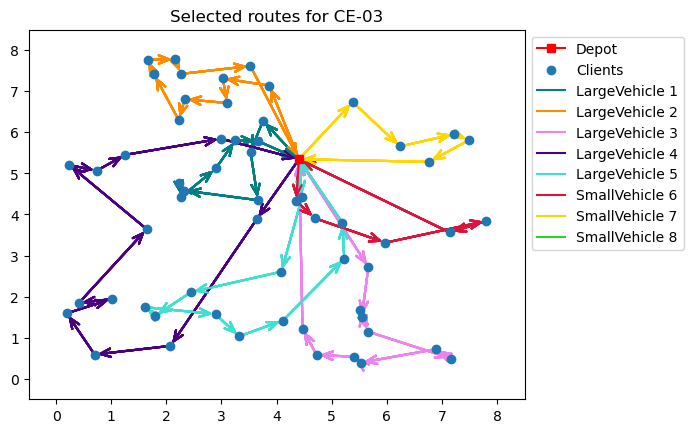

The optimal cost for the distance traveled is: 75.28 €
Route for vehicle k1: 0 -> 41 -> 9 -> 44 -> 2 -> 13 -> 20 -> 55 -> 40 -> 11 -> 0
Route for vehicle k2: 0 -> 54 -> 34 -> 28 -> 43 -> 48 -> 27 -> 7 -> 42 -> 47 -> 22 -> 0
Route for vehicle k3: 0 -> 1 -> 21 -> 59 -> 56 -> 5 -> 45 -> 58 -> 14 -> 15 -> 17 -> 0
Route for vehicle k4: 0 -> 49 -> 18 -> 53 -> 16 -> 6 -> 8 -> 50 -> 10 -> 35 -> 23 -> 60 -> 0
Route for vehicle k5: 0 -> 37 -> 3 -> 26 -> 39 -> 51 -> 38 -> 19 -> 52 -> 36 -> 12 -> 0
Route for vehicle k6: 0 -> 24 -> 46 -> 57 -> 30 -> 4 -> 0
Route for vehicle k7: 0 -> 31 -> 25 -> 32 -> 29 -> 33 -> 0
Route for vehicle k8: 0
Runtime = 3600.1556701660156
---------------------------
Feasibility check:
Total capacity: 910.0
Total amount delivered: 778
Capacity of large vehicles: 140
Amount delivered by vehicle k1: 119
Amount delivered by vehicle k2: 132
Amount delivered by vehicle k3: 129
Amount delivered by vehicle k4: 139
Amount delivered by vehicle k5: 131
Amount delivered by vehicle k

In [10]:
# Params + User cut
############ Instance Initialization CE-03 ############
name = "CE-03"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=3,
                                                                     clients=60,
                                                                     S1=5,
                                                                     S2=3,
                                                                     Q1=140,
                                                                     dmin=12,
                                                                     dmax=15)
############ model8 Construction ############
model8, x, y, u, z, c2 = build_model("model8")
for k in c2:
    c2[k].Lazy = -1
    
model8.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
    
############ model8 Solving ############
model8.reset()
model8x = model8.copy()
model8x.setObjective(0.0)
for c in model8x.getConstrs():
    sense = c.Sense
    if sense != '>':
        model8x.addVar(obj=1.0, name="ArtN_" + c.ConstrName, column=gp.Column([-1], [c]))
    if sense != '<':
        model8x.addVar(obj=1.0, name="ArtP_" + c.ConstrName, column=gp.Column([1], [c]))
model8x.optimize()
model8.feasRelaxS(0, True, False, True)
# model8.Params.MIPFocus = 3
model8.Params.TimeLimit = timelimCE  # Time limit
model8.Params.NoRelHeurTime = 1200
model8.Params.LogFile = name+".log"
model8.read("MIPStarts\CE-03x.sol")
model8.optimize()

############ Plotting Solution ############
if model8.solcount >= 1:
    model8.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model8.getAttr('X', x)
    yvals = model8.getAttr('X', y)
    print_route(objective=model8.objVal, edges=selected(vals))
    times.append(model8.runtime)
    print(f"Runtime = {model8.runtime}")
    feasibility_check(yvals)
    objectives.append(model8.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-04</font>**

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-14
Discarded solution information
Set parameter TimeLimit to value 3600
Set parameter NoRelHeurTime to value 400
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 91299 rows, 47400 columns and 362400 nonzeros
Model fingerprint: 0xe6177309
Variable types: 0 continuous, 47400 integer (46200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e-01, 8e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]

Loaded user MIP start with objective 470.842

Presolve removed 45008 rows and 0 columns
Presolve time: 0.47s
Presolved: 46291 rows, 47400 columns, 228000 nonzeros
Crushed 44408 out of 45008 user cuts to presolved model
Variable types: 0 continuous, 47400 integer (46200 binary)
Starting NoRel heuristic
Found heurist

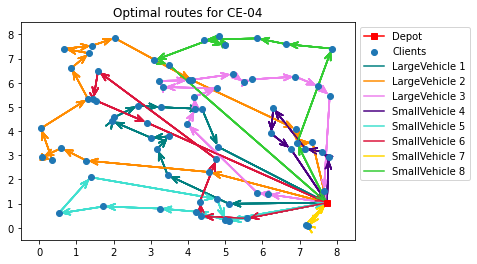

The optimal cost for the distance traveled is: 106.86 €
Route for vehicle k1: 0 -> 37 -> 57 -> 40 -> 20 -> 44 -> 69 -> 8 -> 62 -> 29 -> 1 -> 26 -> 0
Route for vehicle k2: 0 -> 63 -> 34 -> 25 -> 16 -> 18 -> 7 -> 14 -> 33 -> 27 -> 67 -> 43 -> 47 -> 72 -> 12 -> 23 -> 56 -> 0
Route for vehicle k3: 0 -> 42 -> 70 -> 54 -> 36 -> 32 -> 68 -> 59 -> 38 -> 45 -> 39 -> 46 -> 3 -> 65 -> 31 -> 6 -> 19 -> 0
Route for vehicle k4: 0 -> 2 -> 21 -> 71 -> 22 -> 10 -> 64 -> 0
Route for vehicle k5: 0 -> 52 -> 30 -> 61 -> 5 -> 74 -> 24 -> 15 -> 49 -> 0
Route for vehicle k6: 0 -> 4 -> 35 -> 75 -> 66 -> 11 -> 55 -> 53 -> 51 -> 0
Route for vehicle k7: 0 -> 60 -> 50 -> 0
Route for vehicle k8: 0 -> 23 -> 13 -> 58 -> 28 -> 48 -> 41 -> 73 -> 17 -> 9 -> 0
Runtime = 3600.8252868652344
---------------------------
Feasibility check:
Total capacity: 1155.0
Total amount delivered: 975
Capacity of large vehicles: 210
Amount delivered by vehicle k1: 145
Amount delivered by vehicle k2: 209
Amount delivered by vehicle k3: 20

In [10]:
# Params + MIPStart + User cuts
############ Instance Initialization CE-04 ############
name = "CE-04"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=4,
                                                                     clients=75,
                                                                     S1=3,
                                                                     S2=5,
                                                                     Q1=210,
                                                                     dmin=12,
                                                                     dmax=15)
############ model9 Construction ############
model9, x, y, u, z, c2 = build_model("model9")
for k in c2:
    c2[k].Lazy = -1

############ model9 Solving ############
model9.reset()
model9.Params.TimeLimit = timelimCE  # Time limit
model9.Params.NoRelHeurTime = 400
model9.Params.MIPFocus = 3
model9.read("CE-04.sol")
model9.optimize()

############ Plotting Solution ############
if model9.solcount >= 1:
    # model9.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model9.getAttr('X', x)
    yvals = model9.getAttr('X', y)
    print_route(objective=model9.objVal, edges=selected(vals))
    times.append(model9.runtime)
    print(f"Runtime = {model9.runtime}")
    feasibility_check(yvals)
    objectives.append(model9.objVal)
else:
    print("No feasible solution found")

## **<font color="#FBBF44">CE-05</font>**

Discarded solution information
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 161724 rows, 246640 columns and 806640 nonzeros
Model fingerprint: 0x5bfe62c1
Variable types: 163440 continuous, 83200 integer (81600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1310.0000000
Presolve removed 8 rows and 116 columns
Presolve time: 0.95s
Presolved: 161716 rows, 246524 columns, 805724 nonzeros
Crushed 8 out of 8 user cuts to presolved model
Found heuristic solution: objective 1302.0000000
Variable types: 0 continuous, 246524 integer (81600 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...


Use crossover to convert LP symmetric solution to basic solution...

Root crossover log...

   1205

Found heuristic solution: objective 111.6711821
Elapsed time for NoRel heuristic: 345s (best bound 62.8778)
Elapsed time for NoRel heuristic: 366s (best bound 62.8778)
Elapsed time for NoRel heuristic: 381s (best bound 62.8778)
Elapsed time for NoRel heuristic: 402s (best bound 62.8778)
Found heuristic solution: objective 111.5977384
Elapsed time for NoRel heuristic: 453s (best bound 62.8778)
Found heuristic solution: objective 110.3270834
Elapsed time for NoRel heuristic: 476s (best bound 62.8778)
Elapsed time for NoRel heuristic: 494s (best bound 62.8778)
Elapsed time for NoRel heuristic: 526s (best bound 62.8778)
Found heuristic solution: objective 110.2859302
Elapsed time for NoRel heuristic: 541s (best bound 62.8778)
Elapsed time for NoRel heuristic: 569s (best bound 62.8778)
Found heuristic solution: objective 110.1789024
Elapsed time for NoRel heuristic: 597s (best bound 62.8778)
Found heuristic solution: objective 110.1765748
Elapsed time for NoRel heuristic: 621s (best bound 6

   641   664   75.14444   12  547  109.88495   74.96336  31.8%   302 2574s
   682   714   74.99267   14  988  109.88495   74.97046  31.8%   299 2596s
   732   764   75.28519   12  774  109.88495   74.97604  31.8%   293 2618s
   783   814   75.61058   19  873  109.88495   74.97895  31.8%   287 2642s
   833   851   74.98147   17  727  109.88495   74.98147  31.8%   281 2667s
   872   909   75.55442   18  719  109.88495   74.98612  31.8%   281 2695s
   930   977   75.47700   14  904  109.88495   74.98861  31.8%   277 2725s
   998  1043   75.04266   14  891  109.88495   74.99112  31.8%   273 2758s
  1065  1044   75.77375   13  652  109.88495   74.99157  31.8%   271 2780s
  1067  1045   75.11767   16  717  109.88495   74.99157  31.8%   271 2831s
H 1067   992                     109.8849509   74.99157  31.8%   271 2859s
  1068   993   75.12388   20  676  109.88495   74.99157  31.8%   270 2877s
  1069   994   75.45693   28  791  109.88495   74.99157  31.8%   270 2881s
  1070   994   75.19339  

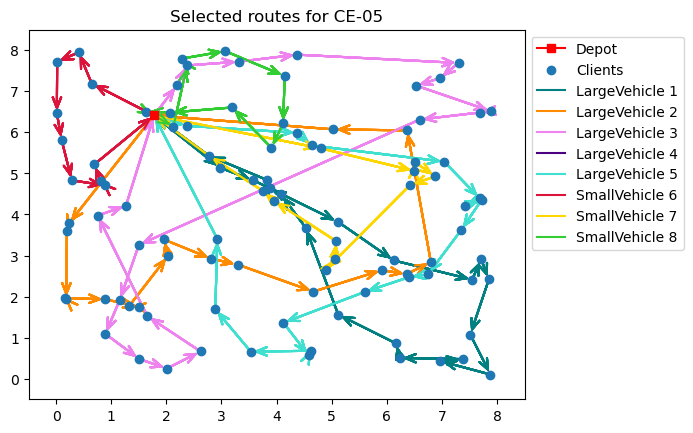

The optimal cost for the distance traveled is: 109.88 €
Route for vehicle k1: 0 -> 88 -> 95 -> 76 -> 6 -> 80 -> 27 -> 46 -> 79 -> 100 -> 1 -> 43 -> 33 -> 50 -> 38 -> 59 -> 86 -> 51 -> 92 -> 83 -> 0
Route for vehicle k2: 0 -> 52 -> 30 -> 34 -> 97 -> 54 -> 71 -> 26 -> 23 -> 73 -> 75 -> 99 -> 78 -> 11 -> 74 -> 93 -> 69 -> 18 -> 0
Route for vehicle k3: 0 -> 15 -> 8 -> 16 -> 49 -> 63 -> 42 -> 58 -> 39 -> 28 -> 64 -> 9 -> 25 -> 81 -> 29 -> 55 -> 24 -> 2 -> 65 -> 13 -> 0
Route for vehicle k4: 0
Route for vehicle k5: 0 -> 17 -> 68 -> 19 -> 14 -> 87 -> 62 -> 56 -> 3 -> 82 -> 96 -> 32 -> 37 -> 98 -> 35 -> 12 -> 66 -> 72 -> 0
Route for vehicle k6: 0 -> 10 -> 70 -> 44 -> 36 -> 89 -> 67 -> 91 -> 84 -> 53 -> 0
Route for vehicle k7: 0 -> 20 -> 61 -> 48 -> 90 -> 41 -> 5 -> 57 -> 60 -> 77 -> 45 -> 83 -> 0
Route for vehicle k8: 0 -> 21 -> 8 -> 22 -> 85 -> 7 -> 94 -> 4 -> 47 -> 40 -> 31 -> 0
Runtime = 3600.6085166931152
---------------------------
Feasibility check:
Total capacity: 1625.0
Total amount de

In [11]:
############ Instance Initialization CE-05 ############
name = "CE-05"
n, xc, yc, points, N, V, K, K1, K2, A, Ak, S, Q, d, c = instance_gen(seed=5,
                                                                     clients=100,
                                                                     S1=5,
                                                                     S2=3,
                                                                     Q1=250,
                                                                     dmin=12,
                                                                     dmax=15)
############ model10 Construction ############
model10, x, y, u, z, c2 = build_model("model10")
for k in c2:
    c2[k].Lazy = -1
    
# model10.addConstrs(quicksum(d[j]*x[i,j,k] for j in N for i in V if i!=j) <= Q[k] for k in K)
    
############ model10 Solving ############
model10.reset()
model10x = model10.copy()
model10x.setObjective(0.0)
for c in model10x.getConstrs():
    sense = c.Sense
    if sense != '>':
        model10x.addVar(obj=1.0, name="ArtN_" + c.ConstrName, column=gp.Column([-1], [c]))
    if sense != '<':
        model10x.addVar(obj=1.0, name="ArtP_" + c.ConstrName, column=gp.Column([1], [c]))
model10x.optimize()
model10.feasRelaxS(0, True, False, True)
model10.Params.MIPFocus = 3
model10.Params.TimeLimit = timelimCE  # Time limit
model10.Params.NoRelHeurTime = 1200
model10.Params.LogFile = name+".log"
model10.read("MIPStarts\CE-05x.sol")
model10.optimize()

############ Plotting Solution ############
if model10.solcount >= 1:
    model10.write(name+"x.sol")
    active_arcs = [a for a in Ak if x[a].x > .99]
    plot_sol(xc, yc, K1, K2, active_arcs, name)

    vals = model10.getAttr('X', x)
    yvals = model10.getAttr('X', y)
    print_route(objective=model10.objVal, edges=selected(vals))
    times.append(model10.runtime)
    print(f"Runtime = {model10.runtime}")
    feasibility_check(yvals)
    objectives.append(model10.objVal)
else:
    print("No feasible solution found")